<h1 align="center">OpenSAFELY Service Restoration Observatory (SRO) - Changes in key GP measures during the pandemic (Demographics)</h1>

The aim of the OpenSAFELY SRO is to describe trends and variation in clinical activity codes to evaluate NHS service restoration during the COVID-19 pandemic.

The purpose of this notebook is to provide a demographic breakdown of key GP measures, that are indicative of changes in overall activity during the pandemic.  For each of these measures we provide a link to the codelist containing all the codes used for that measure, a description of what the measure is and a brief overview of why the measure is important.  We also highlight any caveats, where there are any, for each measure.  For each measure monthly population level rates of recorded activity are provided as well as a break down by ethnicity.

The following key measures are provided:
* [Blood Pressure Monitoring](#systolic_bp)
* [Cardiovascular Disease 10 Year Risk Assessment](#qrisk2)
* [Cholesterol Testing](#cholesterol)
* [Liver Function Testing - Alanine Transferaminase (ALT)](#ALT)
* [Thyroid Testing](#serum_tsh)
* [Full Blood Count - Red Blood Cell (RBC) Testing](#rbc_fbc)
* [Glycated Haemoglobin A1c Level (HbA1c)](#hba1c)
* [Renal Function Assessment - Sodium Testing](#serum_sodium)
* [Asthma Reviews](#asthma)
* [Chronic Obstrutive Pulmonary Disease (COPD) Reviews](#copd)

In [70]:
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
from utilities import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [75]:
sentinel_measures = ['systolic_bp']

demographics = ['region', 'age_band', 'imd']

data_dict = {}
data_dict_totals = {}


for measure in sentinel_measures:
    
    demographics_dict = {}
    
    for d in demographics:
        df = pd.read_csv(f'../output/measure_{measure}_{d}.csv')
        df = redact_small_numbers(df, 5, [measure, 'population'])
        df = df[df['age_band'] != 'missing']

        
        if d == 'age_band':
            df = calculate_rate_standardise(df, measure, 'population', standardise=False)
            
        else:
            df = calculate_rate_standardise(df, measure, 'population', standardise=True, age_group_column='age_band')
        
        
        if d == 'imd':
            
            df = calculate_imd_group(df, measure, 'rate_standardised')
        
        elif d == 'ethnicity':
            df = convert_ethnicity(df)
        
    
        if d== 'age_band':

            df = df.groupby(by=[d, 'date', 'practice'])['rate'].mean().reset_index()
            df = df.groupby(by=[d, 'date'])['rate'].median().reset_index()
            
        else:
            
            df = df.groupby(by=[d, 'date', 'practice'])['rate_standardised'].mean().reset_index()
            df = df.groupby(by=[d, 'date'])['rate_standardised'].median().reset_index()
        
       
        demographics_dict[d] = df
            
    data_dict[measure] = demographics_dict
    
    
    total_df = pd.read_csv(f'../output/measure_{measure}.csv')
   
    total_df = calculate_rate_standardise(total_df, measure, 'population', standardise=False)
    
    total_df = total_df.groupby(by=['date', 'practice'])['rate'].mean().reset_index()
  
    total_df = total_df.groupby(by=['date'])['rate'].median().reset_index()
    
    
    data_dict_totals[measure] = total_df.groupby(by=['date'])['rate'].mean().reset_index()
    

In [76]:
def plot_demographics(data_dict, data_totals, demographics, interactive):
    if interactive:
    
        fig = go.Figure()
        buttons_list = []
        visible_list = []


        #add population rate
        fig.add_trace(go.Scatter(
                        x=data_totals['date'], y=data_totals['rate'], name='total', visible=True))


        for d in demographics:
            df = data_dict[d]


            visible_list.append(len(df[d].unique()))
            for unique_category in df[d].unique():

                    df_subset = df[df[d] == unique_category]

                    if d == 'age_band':

                        fig.add_trace(go.Scatter(
                        x=df_subset['date'], y=df_subset['rate'], name=str(unique_category), visible=False))
                    else:
                        fig.add_trace(go.Scatter(
                        x=df_subset['date'], y=df_subset['rate_standardised'], name=str(unique_category), visible=False))


        buttons_list.append(
            dict(label = 'Total Population Rate',
                          method = 'update',
                          args = [{'visible': [True] + [False]*sum(visible_list)},
                                  {'title': 'Total Population Rate',
                                   'showlegend':True}])
            )


        for i, d in enumerate(demographics):




            visible=[False]
            for j, x in enumerate(visible_list):
                if i == j:
                    visible.extend([True]*x)
                else:
                    visible.extend([False]*x)




            buttons_list.append(
            dict(label = d,
                          method = 'update',
                          args = [{'visible': visible},
                                  {'title': d,
                                   'showlegend':True}])
            )


        fig.update_layout(
        updatemenus=[
            dict(active=0,
                buttons=buttons_list,
                direction="down",
                pad={"r": 10, "t": 10},

                x=1.0,
                xanchor="left",
                y=1.3,
                yanchor="top"
            ),
        ]
    )




        # Set title
        fig.update_layout(
            hovermode='x',
            title_x=0.5,


        )

        fig.update_yaxes(title='Age standardised rate per 1000')
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()
    
    else:
        
        for d in demographics:
           
            plt.plot(data_totals['date'], data_totals['rate'])
            df = data_dict[d]



            for unique_category in df[d].unique():

                    df_subset = df[df[d] == unique_category]

                    if d == 'age_band':
                        plt.plot(df_subset['date'], df_subset['rate'])

                    else:
                        plt.plot(df_subset['date'], df_subset['rate_standardised'])
            plt.xticks(rotation=90)
            plt.ylabel("rate per 1000")
            plt.legend(['total'] + list(df[d].unique()))
            plt.title(d)
            plt.savefig(f'../output/test_{d}.png')
            plt.clf()
            plt.close()


<a id="systolic_bp"></a>
### Blood Pressure Monitoring

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/systolic-blood-pressure-qof/3572b5fb/">this codelist</a>.

#### What it is
Rate of systolic blood presure monitoring per 1000 members of the population.

#### Why it matters
* The measurement of blood pressure and identification and management of hypertension is important for both primary and secondary prevention of cardiovascular disease, such as stroke, myocardial infarction and kidney disease. 
* If patients cannot have their blood pressure measurements acted on by primary care, they may not benefit from averting associated complications. 
* Active management and prevention of these complications is generally provided by Primary Care; as a measure it would therefore be considered an important marker of access to and provision of care.

#### Caveats
None

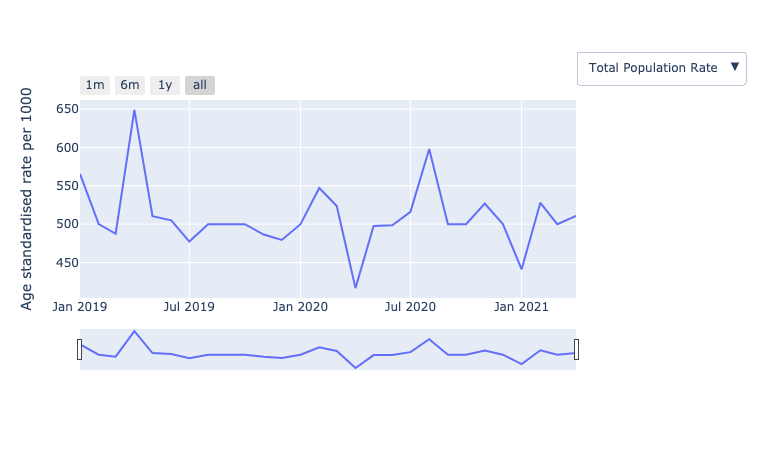

In [77]:
plot_demographics(data_dict['systolic_bp'], data_dict_totals['systolic_bp'],demographics, interactive=True)

In [78]:
plot_demographics(data_dict['systolic_bp'], data_dict_totals['systolic_bp'],demographics, interactive=False)